<a href="https://colab.research.google.com/github/Gfecito/STT3795-SentimentAnalysis/blob/main/CNN_RNN_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from keras.layers import LSTM, Flatten, Conv1D, MaxPool1D, Bidirectional, Embedding, SpatialDropout1D, Attention, BatchNormalization, GlobalMaxPool1D
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("/content/drive/MyDrive/STT3795/Projet/Data/emotion.csv", encoding='latin-1', header=None)

In [3]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
label_sentiment_dict = {0: "Negative", 4: "Positive"}
def label_map(a):
  return label_sentiment_dict[a]

df[0] = df[0].apply(label_map)

In [5]:
import re
import string
def cleaning(a):
    a = str(a).lower()
    a = re.sub('\[.*?\]', '', a)
    a = re.sub('[%s]' % re.escape(string.punctuation), '', a)
    a = re.sub('\n', '', a)
    a = re.sub('https?://\S+|www\.\S+', '', a)
    a = re.sub('<.*?>+', '', a)
    a = re.sub('\w*\d\w*', '', a)
    return a

df[5] = df[5].apply(cleaning)

In [6]:
# vocab_size = 100000 #vocabulary size
maxlength = 30     #max length for each 

x_train = df[5].to_numpy()
y_train = df[0].to_numpy()

In [7]:
import re
import string
from tqdm import tqdm

# https://www.datacamp.com/tutorial/stemming-lemmatization-python 
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

for i in tqdm(range(len(x_train))):
  x_train[i] = stemSentence(x_train[i])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
100%|██████████| 1600000/1600000 [07:21<00:00, 3627.23it/s]


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.05, random_state=22)

Tokenize

In [10]:
#Tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()

In [11]:
tokenizer.fit_on_texts(X_train)

In [12]:
vocab_size = len(tokenizer.word_index) + 1

In [13]:
texts_to_int = tokenizer.texts_to_sequences(X_train)

In [14]:
#Padding
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int,
                                                              maxlen=30,)

In [15]:
texts_to_int_test = tokenizer.texts_to_sequences(X_test)
texts_to_int_pad_test = keras.preprocessing.sequence.pad_sequences(texts_to_int_test,
                                                              maxlen=30,)
X_test = texts_to_int_pad_test

In [16]:
X_train = texts_to_int_pad

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [19]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [20]:
#Model 1
emb_dim = 300

inputs = Input(shape=(maxlength, ))

embedding_layer = Embedding(vocab_size, emb_dim, input_length=maxlength)
x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)
x = Conv1D(32, 5, activation='relu')(x)
# Passed on to the LSTM layer
x = Bidirectional(LSTM(32, dropout=0.4, recurrent_dropout=0.4))(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
# Passed on to activation layer to get final output
out = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=out)

In [21]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [22]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
history = model.fit(X_train, y_train, 
                    batch_size=1028, epochs=2, 
                   )

Epoch 1/2
1479/1479 [==============================] - 407s 264ms/step - loss: 0.4324 - accuracy: 0.7987
Epoch 2/2
1479/1479 [==============================] - 350s 236ms/step - loss: 0.3286 - accuracy: 0.8581


In [27]:
def plot_history(history):
    import matplotlib.pyplot as plt
    acc = history.history['accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Train accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Train loss')
    plt.title('Training and validation loss')
    plt.legend()

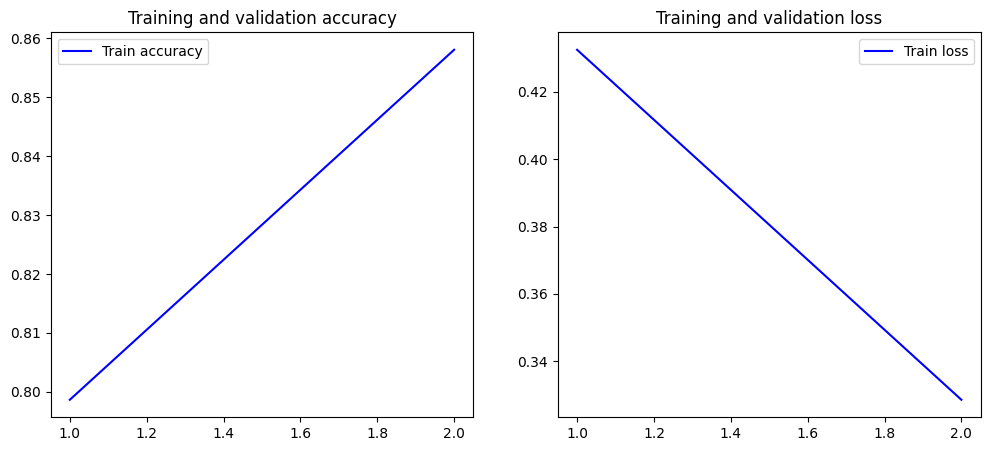

In [28]:
plot_history(history)

In [29]:
preds1 = model.predict(X_test)

2500/2500 [==============================] - 40s 16ms/step


In [30]:
classes1 = np.argmax(preds1, axis=1)

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_test, classes1))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     39896
           1       0.82      0.81      0.82     40104

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000

